In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from torch._utils import _accumulate
def random_split(dataset, lengths):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = torch.randperm(sum(lengths))
    return [torch.utils.data.Subset(dataset, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]

## FashionMNIST

In [3]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/f_mnist', train=True, download=True))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data/f_mnist', train=False, download=True))

0it [00:00, ?it/s]

100%|█████████▉| 26419200/26421880 [10:22<00:00, 111327.07it/s]

Extracting ./data/f_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/f_mnist/FashionMNIST/raw



0it [00:00, ?it/s]


 56%|█████▌    | 16384/29515 [00:05<00:00, 75373.20it/s]
32768it [00:05, 88836.45it/s]                           
0it [00:00, ?it/s]

Extracting ./data/f_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/f_mnist/FashionMNIST/raw



 31%|███       | 1359872/4422102 [00:11<00:24, 124271.51it/s]
26427392it [10:40, 111327.07it/s]                              A
 47%|████▋     | 2080768/4422102 [00:21<00:23, 101371.78it/s]


 95%|█████████▍| 4186112/4422102 [00:41<00:02, 109096.52it/s]


100%|█████████▉| 4415488/4422102 [00:43<00:00, 106089.28it/s]

0it [00:00, ?it/s]

Extracting ./data/f_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/f_mnist/FashionMNIST/raw




  0%|          | 0/5148 [00:11<?, ?it/s]

Extracting ./data/f_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/f_mnist/FashionMNIST/raw
Processing...
Done!


In [4]:
data   = dl_train.dataset.data.to(dtype=torch.float32)
labels = dl_train.dataset.targets

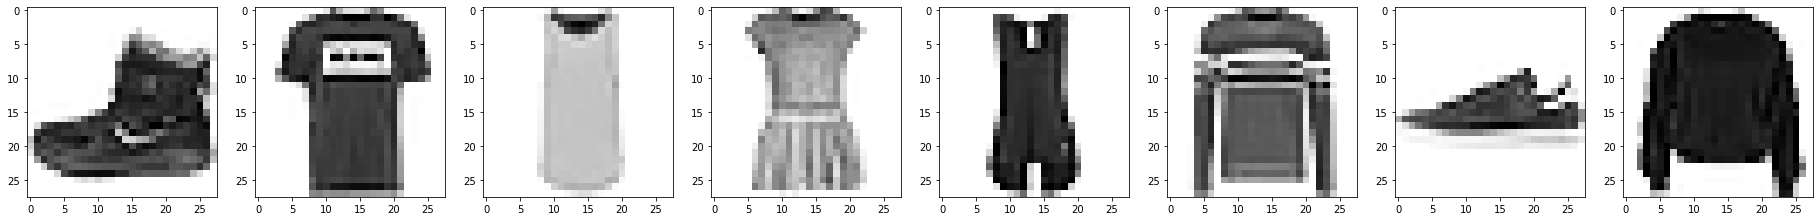

In [5]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
for i in range(8):
    ax[i].imshow(data[i].numpy(), cmap='Greys');

In [6]:
labels[0:8]

tensor([9, 0, 0, 3, 0, 2, 7, 2])

In [7]:
dataset = torch.utils.data.TensorDataset( 
    (data/256.0).view(-1,28*28), 
    labels)

In [8]:
train_dataset, validation_dataset = random_split(dataset, (50000,10000))

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [10]:
datasets = [
    torch.utils.data.Subset(train_dataset,torch.randint(len(train_dataset),(len(train_dataset),))) for i in range(5)]

In [11]:
train_loaders = [torch.utils.data.DataLoader(d, 
                                           batch_size=100, 
                                           shuffle=True) for d in datasets]

In [12]:
test_data   = dl_test.dataset.data.to(dtype=torch.float32)
test_labels = dl_test.dataset.targets
test_dataset = torch.utils.data.TensorDataset(
    (test_data/256.0).view(-1,28*28), test_labels)

In [13]:
models = [torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Linear(1200,10)
) for i in range(len(datasets))]

In [14]:
optims = [torch.optim.SGD(models[i].parameters(), lr=0.01, momentum=0.6) for i in range(len(datasets))]

In [15]:
loss_f = nn.CrossEntropyLoss()

In [16]:
%%time
for i in range(len(datasets)):
    for e in range(10):
        for d in train_loaders[i]:        
            optims[i].zero_grad()
            features, labels = d
            pred = models[i](features)
            loss = loss_f(pred, labels)
            loss.backward()
            optims[i].step()
        print(i,e,loss.item())        


4423680it [01:01, 106089.28it/s]                             

0 0 0.7433028221130371
0 1 0.6619833111763
0 2 0.36267971992492676
0 3 0.3801907002925873
0 4 0.45917755365371704
0 5 0.4451729953289032
0 6 0.28702104091644287
0 7 0.3658377528190613
0 8 0.2330213040113449
0 9 0.31461310386657715
1 0 0.7444758415222168
1 1 0.48866671323776245
1 2 0.4677034020423889
1 3 0.6180479526519775
1 4 0.5237935781478882
1 5 0.3869703412055969
1 6 0.43017253279685974
1 7 0.2626284658908844
1 8 0.3350714147090912
1 9 0.3977390229701996
2 0 0.6088564395904541
2 1 0.5282242298126221
2 2 0.4595123529434204
2 3 0.36077332496643066
2 4 0.4426266551017761
2 5 0.6680627465248108
2 6 0.4576907753944397
2 7 0.4117852449417114
2 8 0.3390873372554779
2 9 0.3492666482925415
3 0 0.7527427673339844
3 1 0.7051754593849182
3 2 0.41933485865592957
3 3 0.6730900406837463
3 4 0.48170870542526245
3 5 0.36175593733787537
3 6 0.4642467498779297
3 7 0.32766979932785034
3 8 0.3523498773574829
3 9 0.32943612337112427
4 0 0.7142040133476257
4 1 0.4872399568557739
4 2 0.6384567022323608
4 

In [17]:
with torch.no_grad():
    for i in range(len(datasets)):
        pred = torch.softmax(models[i](datasets[i][:][0]),1)
        ac = torch.sum(torch.argmax(pred,1)==datasets[i][:][1]).to(dtype=torch.float32)/len(datasets[i])
        print(ac)  

tensor(0.8762)
tensor(0.8818)
tensor(0.8831)
tensor(0.8833)
tensor(0.8771)


In [18]:
with torch.no_grad():
    for i in range(len(datasets)):
        pred = torch.softmax(models[i](validation_dataset[:][0]),1)
        ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(test_dataset)
        print(ac)    

tensor(0.8656)
tensor(0.8661)
tensor(0.8688)
tensor(0.8667)
tensor(0.8608)


In [19]:
def predict_class (model, inp):
    pred = torch.softmax(model(inp),dim=1)
    return torch.argmax(pred,dim=1)

In [20]:
preds = [predict_class(models[i], validation_dataset[:][0]) for i in range(len(datasets))]

In [21]:
preds

[tensor([5, 8, 1,  ..., 7, 4, 1]),
 tensor([5, 8, 1,  ..., 7, 4, 1]),
 tensor([5, 8, 1,  ..., 7, 4, 1]),
 tensor([5, 8, 1,  ..., 7, 4, 1]),
 tensor([5, 8, 1,  ..., 7, 4, 1])]

In [22]:
def vote(predictions):
    npred=torch.stack(predictions, dim=1).numpy()
    v  = np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, npred)
    return torch.from_numpy(v)  

In [23]:
gold = vote(preds)

In [24]:
torch.sum(gold==validation_dataset[:][1]).item()/len(gold)

0.8697

## Dropout 

<p style="text-align:center"><img style="padding:24pt" src="dropout.png"/></p>

In [25]:
model = torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1200,10)
)

In [26]:
optim = torch.optim.SGD(model.parameters(), lr=0.01 , momentum=0.6)

In [27]:
model.train()
for e in range(10):
        for d in train_loader:        
            optim.zero_grad()
            features, labels = d
            pred = model(features)
            loss = loss_f(pred, labels)
            loss.backward()
            optim.step()
        print(e,loss.item())        

0 0.9689186811447144
1 0.7463081479072571
2 0.5247896313667297
3 0.3879178762435913
4 0.5865035057067871
5 0.44436702132225037
6 0.39764201641082764
7 0.5194501280784607
8 0.3794068396091461
9 0.5405982732772827


In [28]:
model.eval()
pred = torch.softmax(model(train_dataset[:][0]),1)
ac = torch.sum(torch.argmax(pred,1)==train_dataset[:][1]).to(dtype=torch.float32)/len(train_dataset)
print(ac)
pred = torch.softmax(model(validation_dataset[:][0]),1)
ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(validation_dataset)
print(ac)

tensor(0.8681)
tensor(0.8639)
